# Neural Networks Course - LEONARDO H. DE MORAES - Final Project  

**Name:** Leonardo H. de Moraes  
**Student ID:** 1711609  

**Course:** Neural Networks - Polytechnic Institute of Guarda (IPG)  
**Acronym:** LEI  
**Department:** School of Technology and Management  
**Degree:** Bachelor's  
**Program:** Computer Engineering  
**Academic Year:** 2024/2025  
**Professor:** Noel de Jesus Mendonça Lopes  

---

## Project Objective  
The goal of this project is to develop predictive models for the exchange rates of the US Dollar (**USD**) and the Japanese Yen (**JPY**) against the Euro (**EUR**). Students will use neural networks to build and compare different models.  

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from datetime import datetime, timedelta


2025-05-24 02:24:41.054340: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-24 02:24:41.060957: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-24 02:24:41.073910: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748049881.096790   29321 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748049881.102038   29321 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748049881.118859   29321 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [ ]:

class ForexPredictor:
    def __init__(self, data_path):
        self.data_path = data_path
        self.model = None
        self.scaler_X = MinMaxScaler()
        self.scaler_y = MinMaxScaler()
        self.forecast_dates = None
        self.forecast_values = None
        self.features = ['exchange_rate_USD_EUR', 'exchange_rate_JPY_EUR', 
                        'oil_price', 'sp500', 'interest_rate',
                        'day_of_week', 'month', 'year']
        self.targets = ['exchange_rate_USD_EUR', 'exchange_rate_JPY_EUR']
        
    def load_and_preprocess_data(self):
        """Carrega e pré-processa os dados"""
        df = pd.read_csv(self.data_path)
        df['date'] = pd.to_datetime(df['date'])
        
        # Extrair features e targets
        X = df[self.features].values
        y = df[self.targets].values
        
        # Normalização
        X_scaled = self.scaler_X.fit_transform(X)
        y_scaled = self.scaler_y.fit_transform(y)
        
        # Divisão temporal (80% treino, 20% teste)
        split_idx = int(len(X_scaled) * 0.8)
        return (X_scaled[:split_idx], y_scaled[:split_idx], 
                X_scaled[split_idx:], y_scaled[split_idx:], df)
    
    

    def build_model(self, input_shape):
        """Constrói o modelo de rede neural com backpropagation"""
        model = Sequential([
            Dense(128, input_dim=input_shape, activation='relu'),
            Dropout(0.3),
            Dense(64, activation='relu'),
            Dropout(0.2),
            Dense(32, activation='relu'),
            Dense(16, activation='relu'),
            Dense(len(self.targets), activation='linear')
        ])
        
        optimizer = Adam(learning_rate=0.0005)
        model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])
        
        return model
    

    
    def train_model(self, X_train, y_train, X_test, y_test):
        """Treina o modelo com early stopping"""
        early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
        
        history = self.model.fit(
            X_train, y_train,
            validation_data=(X_test, y_test),
            epochs=10000,
            batch_size=32,
            verbose=1,
            callbacks=[early_stop]
        )
        return history
    

    
    def make_predictions(self, X_test, y_test, df):
        """Faz previsões e avalia o modelo"""
        # Avaliação no conjunto de teste
        y_pred_scaled = self.model.predict(X_test)
        y_pred = self.scaler_y.inverse_transform(y_pred_scaled)
        y_true = self.scaler_y.inverse_transform(y_test)
        
        # Cálculo do RMSE
        rmse_usd = np.sqrt(mean_squared_error(y_true[:, 0], y_pred[:, 0]))
        rmse_jpy = np.sqrt(mean_squared_error(y_true[:, 1], y_pred[:, 1]))
        
        # Previsão para os próximos 5 dias
        last_dates = [df['date'].iloc[-1] + timedelta(days=i) for i in range(1, 6)]
        
        # Criar dados de entrada para previsão
        last_features = df[self.features].iloc[-1:].values
        
        # Para cada dia de previsão, podemos ajustar algumas features conhecidas
        X_forecast = []
        for i in range(1, 6):
            # Criar uma cópia do último registro conhecido
            new_row = last_features.copy()
            
            # Atualizar features que sabemos (como data)
            future_date = df['date'].iloc[-1] + timedelta(days=i)
            new_row[0, self.features.index('day_of_week')] = future_date.weekday()
            new_row[0, self.features.index('month')] = future_date.month
            new_row[0, self.features.index('year')] = future_date.year
            
            X_forecast.append(new_row)
        
        X_forecast = np.concatenate(X_forecast, axis=0)
        X_forecast_scaled = self.scaler_X.transform(X_forecast)
        
        # Fazer previsões
        y_forecast_scaled = self.model.predict(X_forecast_scaled)
        y_forecast = self.scaler_y.inverse_transform(y_forecast_scaled)
        
        self.forecast_dates = last_dates
        self.forecast_values = y_forecast
        
        return rmse_usd, rmse_jpy
    

    



    def plot_results(self, df):
        """Visualiza os resultados com histórico completo e previsões"""
        plt.figure(figsize=(16, 12))
        
        # 1. Preparar dados completos para plotagem
        # Previsões para todo o período histórico
        X_full = self.scaler_X.transform(df[self.features].values)
        y_pred_full_scaled = self.model.predict(X_full)
        y_pred_full = self.scaler_y.inverse_transform(y_pred_full_scaled)
        
        # Criar DataFrame completo para plotagem
        plot_df = df.copy()
        plot_df['USD_EUR_pred'] = y_pred_full[:, 0]
        plot_df['JPY_EUR_pred'] = y_pred_full[:, 1]
        
        # DataFrame com previsões futuras
        future_df = pd.DataFrame({
            'date': self.forecast_dates,
            'USD_EUR_pred': self.forecast_values[:, 0],
            'JPY_EUR_pred': self.forecast_values[:, 1]
        })
        
        # 2. Gráfico para USD/EUR
        plt.subplot(2, 1, 1)
        
        # Plotar dados históricos reais
        plt.plot(plot_df['date'], plot_df['exchange_rate_USD_EUR'], 
                label='Valor Real', color='blue', linewidth=2)
        
        # Plotar previsões do modelo no período histórico
        plt.plot(plot_df['date'], plot_df['USD_EUR_pred'], 
                label='Previsão do Modelo (histórico)', color='red', linestyle='--', linewidth=1.5)
        
        # Plotar previsões futuras
        plt.plot(future_df['date'], future_df['USD_EUR_pred'], 
                'ro--', markersize=8, linewidth=2, label='Previsão Futura (5 dias)')
        
        # Destacar o ponto de transição entre histórico e futuro
        last_date = plot_df['date'].iloc[-1]
        plt.axvline(x=last_date, color='gray', linestyle=':', linewidth=1)
        plt.text(last_date, plt.ylim()[0]*0.95, ' Fim dos Dados\n Históricos', 
                ha='left', va='top', color='gray')
        
        plt.title('USD/EUR - Dados Históricos e Previsões', fontsize=14, pad=20)
        plt.ylabel('Taxa de Câmbio', fontsize=12)
        plt.legend(fontsize=12, loc='upper left')
        plt.grid(True, linestyle='--', alpha=0.7)
        
        # 3. Gráfico para JPY/EUR
        plt.subplot(2, 1, 2)
        
        # Plotar dados históricos reais
        plt.plot(plot_df['date'], plot_df['exchange_rate_JPY_EUR'], 
                label='Valor Real', color='green', linewidth=2)
        
        # Plotar previsões do modelo no período histórico
        plt.plot(plot_df['date'], plot_df['JPY_EUR_pred'], 
                label='Previsão do Modelo (histórico)', color='purple', linestyle='--', linewidth=1.5)
        
        # Plotar previsões futuras
        plt.plot(future_df['date'], future_df['JPY_EUR_pred'], 
                'mo--', markersize=8, linewidth=2, label='Previsão Futura (5 dias)')
        
        # Destacar o ponto de transição
        plt.axvline(x=last_date, color='gray', linestyle=':', linewidth=1)
        plt.text(last_date, plt.ylim()[0]*0.95, ' Fim dos Dados\n Históricos', 
                ha='left', va='top', color='gray')
        
        plt.title('JPY/EUR - Dados Históricos e Previsões', fontsize=14, pad=20)
        plt.ylabel('Taxa de Câmbio', fontsize=12)
        plt.xlabel('Data', fontsize=12)
        plt.legend(fontsize=12, loc='upper left')
        plt.grid(True, linestyle='--', alpha=0.7)
        
        plt.tight_layout()
        plt.show()



In [3]:

# 1. Inicialização e carregamento de dados
dataset_path = "../data/dateset/multi_forex_dataset_2015-01-01_to_2025-05-24.csv"
predictor = ForexPredictor(dataset_path)
X_train, y_train, X_test, y_test, df = predictor.load_and_preprocess_data()


In [4]:

# 2. Construção e treinamento do modelo
predictor.model = predictor.build_model(X_train.shape[1])
print("\nResumo do Modelo:")
predictor.model.summary()

print("\nTreinando o modelo...")
history = predictor.train_model(X_train, y_train, X_test, y_test)



Resumo do Modelo:


/home/leo-moraes/Documents/leo/IPG/Redes_Neurais/final_work_redes_neurais/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
E0000 00:00:1748049887.597240   29321 cuda_executor.cc:1228] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1748049887.598459   29321 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 2)              │            34 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,050 (47.07 KB)

 Trainable params: 12,050 (47.07 KB)

 Non-trainable params: 0 (0.00 B)


Treinando o modelo...
Epoch 1/10000
180/180 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0936 - mae: 0.2342 - val_loss: 0.0575 - val_mae: 0.1982
Epoch 2/10000
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0112 - mae: 0.0837 - val_loss: 0.0437 - val_mae: 0.1737
Epoch 3/10000
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0075 - mae: 0.0677 - val_loss: 0.0430 - val_mae: 0.1723
Epoch 4/10000
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0053 - mae: 0.0563 - val_loss: 0.0340 - val_mae: 0.1518
Epoch 5/10000
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0043 - mae: 0.0510 - val_loss: 0.0290 - val_mae: 0.1367
Epoch 6/10000
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0035 - mae: 0.0451 - val_loss: 0.0312 - val_mae: 0.1366
Epoch 7/10000
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0029 - mae: 0.0412 - val_loss: 0.0289 - val_mae: 0.1253
Epoch 8/10000
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0025 - mae: 0.0375 - val_loss: 0.0302 - val_mae: 0.1230
Epoch 9/1

In [5]:
df

,date,exchange_rate_USD_EUR,exchange_rate_JPY_EUR,oil_price,interest_rate,sp500,day_of_week,month,year,exchange_rate_USD_EUR_pct_change,...,sp500_pct_change,exchange_rate_USD_EUR_ma_7,exchange_rate_JPY_EUR_ma_7,oil_price_ma_7,exchange_rate_USD_EUR_ma_30,exchange_rate_JPY_EUR_ma_30,oil_price_ma_30,exchange_rate_USD_EUR_ma_90,exchange_rate_JPY_EUR_ma_90,oil_price_ma_90
0,2015-01-14,0.8480,0.00724,1.608,0.12,200.86,2,1,2015,-0.106020,...,-0.603721,0.848771,0.007206,1.357429,0.846297,0.007163,10.416900,0.842843,0.007082,9.833967
1,2015-01-14,0.8480,0.00724,1.518,0.12,200.86,2,1,2015,0.000000,...,0.000000,0.848643,0.007211,1.390857,0.846430,0.007167,10.410067,0.843087,0.007086,9.831900
2,2015-01-14,0.8480,0.00724,0.469,0.12,200.86,2,1,2015,0.000000,...,0.000000,0.848514,0.007217,1.392000,0.846563,0.007170,10.381167,0.843250,0.007090,9.818178
3,2015-01-14,0.8480,0.00724,1.261,0.12,200.86,2,1,2015,0.000000,...,0.000000,0.848386,0.007223,1.345857,0.846697,0.007174,8.835200,0.843413,0.007093,9.814533
4,2015-01-14,0.8480,0.00724,1.361,0.12,200.86,2,1,2015,0.000000,...,0.000000,0.848257,0.007229,1.305000,0.846830,0.007178,7.268900,0.843577,0.007097,9.813078
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7158,2025-05-19,0.8891,0.00614,1.555,4.33,594.85,0,5,2025,-0.714685,...,0.109391,0.893743,0.006113,1.555000,0.886137,0.006149,1.555000,0.924979,0.006211,1.555000
7159,2025-05-20,0.8860,0.00613,1.555,4.33,592.85,1,5,2025,-0.348667,...,-0.336219,0.893329,0.006114,1.555000,0.885253,0.006145,1.555000,0.924047,0.006211,1.555000
7160,2025-05-21,0.8825,0.00614,1.555,4.33,582.86,2,5,2025,-0.395034,...,-1.685081,0.890629,0.006123,1.555000,0.884240,0.006144,1.555000,0.923057,0.006210,1.555000
7161,2025-05-22,0.8860,0.00615,1.555,4.33,583.09,3,5,2025,0.396601,...,0.039461,0.889557,0.006136,1.555000,0.884023,0.006143,1.555000,0.922119,0.006209,1.555000


In [6]:

# 3. Previsões e avaliação
rmse_usd, rmse_jpy = predictor.make_predictions(X_test, y_test, df)
print(f"\nPerformance do Modelo:")
print(f"RMSE USD/EUR: {rmse_usd:.6f}")
print(f"RMSE JPY/EUR: {rmse_jpy:.6f}")


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step

Performance do Modelo:
RMSE USD/EUR: 0.022210
RMSE JPY/EUR: 0.000731


224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


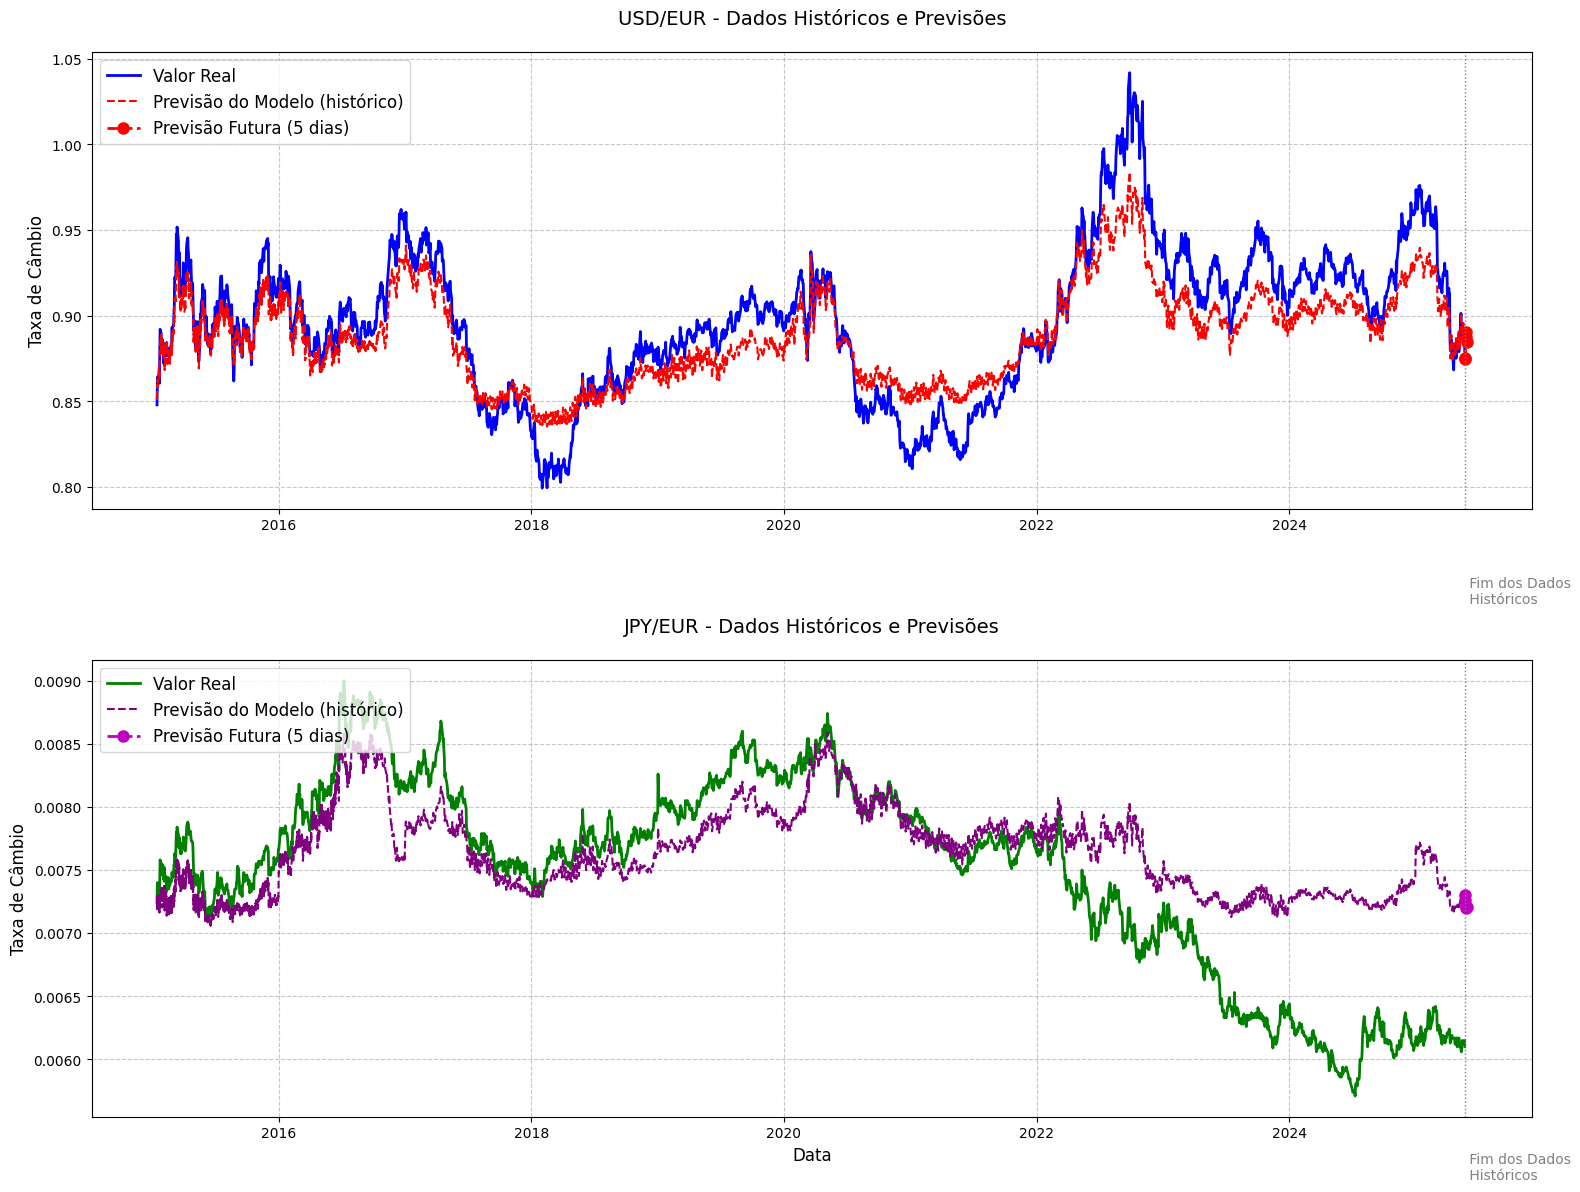

In [7]:

# 4. Visualização
predictor.plot_results(df)


In [ ]:

# 5. Salvar previsões
forecast_df = pd.DataFrame({
    'date': predictor.forecast_dates,
    'USD_EUR_pred': predictor.forecast_values[:, 0],
    'JPY_EUR_pred': predictor.forecast_values[:, 1]
})
forecast_df.to_csv('forex_predictions_enhanced.csv', index=False)
print("\nPrevisões salvas em 'forex_predictions_enhanced.csv'")

